# Tiger Data Challenge 0
*A. Bolton, 2023 July*

Compute Tiger micropupil images for DC0 parameters.

One trick/kluge baked in here is reverse-engineering the input pupil sampling to give the desired micropupil
sampling on the other end.

In [1]:
# Imports:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import skimage.measure

In [2]:
class TigerSystem:
    def __init__(self,
                 diam=6.5*u.m,
                 sec_rad=0.65*u.m,
                 n_supp=3,
                 supp_wid=0.15*u.m,
                 spaxel_arcsec=0.040,
#                 pupil_factor=2, # pupil factor will now be calculated to get desired pixel scale
                 pixel_scale=1.e-6*u.m,
                 npix=2048,
                 oversample=2,
                 spaxel_size=700.e-6*u.m,
                 spaxel_fratio=10.):
    # Stuff that gets specified:
        self.diam = diam
        self.sec_rad = sec_rad
        self.n_supp = n_supp
        self.supp_wid = supp_wid
        self.spaxel_arcsec = spaxel_arcsec
#        self.pupil_factor = pupil_factor
        self.pixel_scale = pixel_scale
        self.npix = npix
        self.oversample = oversample
        self.spaxel_size = spaxel_size
        self.spaxel_fratio = spaxel_fratio
    # Stuff that gets computed:
        # Spaxel focal length:
        self.spaxel_flength = self.spaxel_fratio * self.spaxel_size
        # Implied telescope focal length:
        self.fl_pri = self.spaxel_size / (self.spaxel_arcsec / 206265.)
        # Implied micropupil demagnification:
        self.microp_mu = self.spaxel_flength / self.fl_pri
        # Compute pupil factor:
        self.pupil_factor = self.pixel_scale * self.npix / (self.microp_mu * self.diam)
        # Computational pupil diameter:
        self.pupil_diam = self.pupil_factor * self.diam
        # Physical half-width of simulated microimage:
        self.m_hw = (0.5 * self.microp_mu * self.pupil_diam * self.oversample).to(u.micron).value
    # Build model:
        self.osys = poppy.OpticalSystem(pupil_diameter=self.pupil_diam,
                                        npix=self.npix,
                                        oversample=self.oversample)
        prim_ap = poppy.CircularAperture(radius=self.diam/2.)
        ttstage = poppy.TipTiltStage(prim_ap, radius=self.diam/2.)
        self.osys.add_pupil(ttstage, name='Primary aperture')
        self.osys.add_pupil(poppy.SecondaryObscuration(secondary_radius=self.sec_rad,
                                                       n_supports=self.n_supp,
                                                       support_width=self.supp_wid))
        self.osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'))
        self.osys.add_image(poppy.SquareFieldStop(size=spaxel_arcsec, name='Tiger MLA aperture'))
        self.osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil, name='Far-field pupil'))

In [3]:
# We will compute at 1.e-7um pixels and bin to 1.e-6,
# to get good pupil sampling in the initial calculation.
spaxel_arcsec=0.04
tigersys = TigerSystem(spaxel_arcsec=spaxel_arcsec, n_supp=0, supp_wid=0*u.m, pixel_scale=1.e-7*u.m, npix=4096)
lam_vals = [0.4*u.micron, 1.0*u.micron, 1.7*u.micron]
spax_tip_tilts = [(0.,0.), (0.,1.), (1.,1.)]

In [4]:
# The computation loop:
psf_hdul = fits.HDUList()
for this_tip, this_tilt in spax_tip_tilts:
    for this_lam in lam_vals:
        print(this_tip, this_tilt, this_lam)
        tigersys.osys[0].set_tip_tilt(spaxel_arcsec*this_tip, spaxel_arcsec*this_tilt)
        this_psf, this_wave = tigersys.osys.calc_psf(wavelength=this_lam,
                                                     display_intermediates=False,
                                                     return_intermediates=True)
        # Excise central 1200x1200 pixels of PSF image and normalize to secondary-obscured pupil:
        nyfull, nxfull = this_wave[-1].intensity.shape
        nysub, nxsub = 1200, 1200
        nyoff, nxoff = (nyfull-nysub) // 2, (nxfull-nxsub) // 2
        psf_sub = (this_wave[-1].intensity[nyoff:nyoff+nysub,nxoff:nxoff+nxsub]) / this_wave[1].intensity.sum()
        # Bin to 1-um pixels and accumulate into HDU list:
        psf_binsub = skimage.measure.block_reduce(psf_sub, block_size=10, func=np.sum)
        psf_hdul.append(fits.ImageHDU(psf_binsub))
        psf_hdul[-1].header['DPRIMARY'] = tigersys.diam.to_string(), 'primary diameter'
        psf_hdul[-1].header['RCENTRAL'] = tigersys.sec_rad.to_string(), 'central obscuration radius'
        psf_hdul[-1].header['SPAXSIZE'] = spaxel_arcsec, 'spaxel angular size in arcsec'
        psf_hdul[-1].header['MLA_FL'] = tigersys.spaxel_flength.to_string(), 'MLA spaxel focal length'
        psf_hdul[-1].header['WAVELEN'] = this_lam.to_string(), 'wavelength'
        psf_hdul[-1].header['SPAXTIP'] = this_tip, 'x-tip in units of spaxels'
        psf_hdul[-1].header['SPAXTILT'] = this_tilt, 'y-tilt in units of spaxels'
        psf_hdul[-1].header['PIXSCALE'] = (10*tigersys.pixel_scale).to_string(), 'pixel scale'

0.0 0.0 0.4 micron
0.0 0.0 1.0 micron
0.0 0.0 1.7 micron
0.0 1.0 0.4 micron
0.0 1.0 1.0 micron
0.0 1.0 1.7 micron
1.0 1.0 0.4 micron
1.0 1.0 1.0 micron
1.0 1.0 1.7 micron


In [5]:
# Create mosaic image for display purposes:
ny_psf, nx_psf = psf_hdul[0].data.shape
big_im = np.full((3*ny_psf, 3*nx_psf), 0.)
for k in range(len(psf_hdul)):
    i = k % 3
    j = 2 - (k // 3)
    big_im[j*ny_psf:(j+1)*ny_psf,i*nx_psf:(i+1)*nx_psf] = psf_hdul[k].data

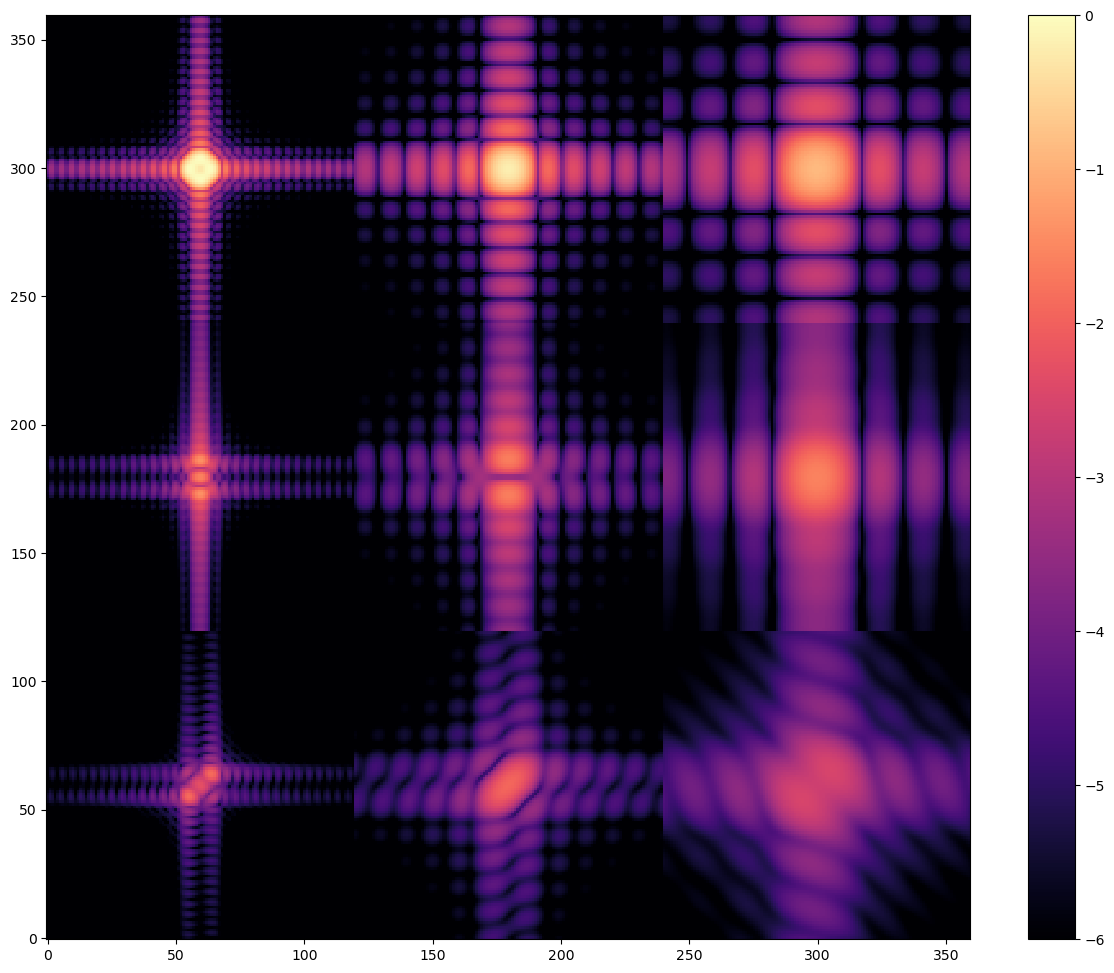

In [6]:
# Display mosaic image in logscale:
plt.figure(figsize=(15,12))
plt.imshow(np.log10(big_im/big_im.max()), origin='lower', interpolation='nearest', cmap='magma', vmin=-6, vmax=0)
plt.colorbar()

In [7]:
# Pack into FITS file:
psf_hdul.writeto('poppy_DC0_v02.fits', overwrite=True)